In [1]:
# Standard libraries
import os
import copy
from math import sqrt

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn core utilities
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.utils import resample, compute_class_weight

# Scikit-learn metrics
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, 
    accuracy_score, roc_auc_score, precision_recall_curve, 
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay, 
    classification_report
)

# Scikit-learn models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# External libraries
import shap
from xgboost import XGBClassifier
import xgboost as xgb

from joblib import Parallel, delayed

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

In [3]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_test = external_validation_cohort['Outcome_Occlusion_MI']
X_test = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_102936\3862442126.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_102936\3862442126.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [4]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(BinaryClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer - NO sigmoid here because we'll use BCEWithLogitsLoss
        self.feature_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)
    
    def forward(self, x):
        features = self.feature_layers(x)
        # Return raw logits - BCEWithLogitsLoss will handle the sigmoid internally
        return self.output_layer(features)

In [7]:
def train_final_model(X_train, y_train, best_params):
    # Convert DataFrames to numpy arrays if needed
    if hasattr(X_train, 'values'):
        X_train = X_train.values
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    
    # Setup device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=best_params['batch_size'], 
        shuffle=True
    )
    
    # Create model with best parameters
    model = BinaryClassifier(
        input_dim=X_train.shape[1],
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate']
    )
    
    # Setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    # Training
    model.to(device)
    model.train()
    
    # Training loop
    n_epochs = 150  # You can adjust this
    best_loss = float('inf')
    best_model_state = model.state_dict().copy()
    patience = 10
    epochs_no_improve = 0
    
    print("Training final model on entire dataset...")
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        
        # Print progress
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")
        
        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    print(f"Training complete. Final loss: {best_loss:.6f}")
    
    return model

In [31]:
def bootstrap_metric_ci(y_true, y_pred, metric_name, n_bootstraps=1000, confidence_level=0.95):
    """
    Calculate confidence intervals for a given metric using bootstrapping.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth labels
    y_pred : array-like
        Predicted probabilities or scores
    metric_name : str
        Name of the metric to calculate ("auroc" for area under ROC curve)
    n_bootstraps : int, optional (default=1000)
        Number of bootstrap samples
    confidence_level : float, optional (default=0.95)
        Confidence level for the interval
    
    Returns:
    --------
    lower_bound, upper_bound : float
        Lower and upper bounds of the confidence interval
    """
    from sklearn.metrics import roc_auc_score
    
    # Initialize array to store bootstrap results
    bootstrap_results = np.zeros(n_bootstraps)
    
    # Get indices for bootstrap sampling
    indices = np.arange(len(y_true))
    
    # Function to compute metric for a bootstrap sample
    def compute_bootstrap(i):
        # Sample with replacement
        bootstrap_indices = resample(indices, replace=True, n_samples=len(indices))
        if metric_name == "auroc":
            # Check if bootstrap sample contains both positive and negative classes
            if len(np.unique(y_true[bootstrap_indices])) < 2:
                return np.nan
            return roc_auc_score(y_true[bootstrap_indices], y_pred[bootstrap_indices])
        else:
            raise ValueError(f"Metric '{metric_name}' not supported")
    
    # Compute bootstrap samples in parallel
    bootstrap_results = Parallel(n_jobs=-1)(
        delayed(compute_bootstrap)(i) for i in range(n_bootstraps)
    )
    
    # Remove NaN values (if any)
    bootstrap_results = np.array([r for r in bootstrap_results if not np.isnan(r)])
    
    # Calculate confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_results, 100 * alpha)
    upper_bound = np.percentile(bootstrap_results, 100 * (1 - alpha))
    
    return lower_bound, upper_bound

def plot_ROC_curves(models, X_train, y_train, X_test, y_test, set_names=("Training Set", "Testing Set"), figsize=(18, 8)):
    """
    Plot ROC curves for multiple models on both training and testing sets.
    
    Parameters:
    -----------
    models : dict
        Dictionary of model name to model object mappings
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Testing features
    y_test : array-like
        Testing labels
    set_names : tuple, optional
        Names for the training and testing sets
    figsize : tuple, optional
        Figure size
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plot
    axes : array of matplotlib Axes
        The axes objects
    results_train : dict
        Dictionary with model names as keys and tuples (auc, ci_lower, ci_upper) as values for training data
    results_test : dict
        Dictionary with model names as keys and tuples (auc, ci_lower, ci_upper) as values for testing data
    """
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define color map for models
    colors = plt.cm.tab10.colors
    
    # Dictionary to store AUROCs and CIs
    results_train = {}
    results_test = {}
    
    # Lists to store legend handles and labels for later sorting
    handles_train = []
    labels_train = []
    handles_test = []
    labels_test = []
    
    # Plot settings
    sample_sizes = (len(y_train), len(y_test))
    
    # Loop through each model
    for i, (model_name, model) in enumerate(models.items()):
        color = colors[i % len(colors)]
        
        # For models without predict_proba, we need to handle differently
        if hasattr(model, 'predict_proba'):
            # Training set
            try:
                y_train_pred = model.predict_proba(X_train)[:, 1]
                fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
                roc_auc_train = auc(fpr_train, tpr_train)
                ci_lower_train, ci_upper_train = bootstrap_metric_ci(y_train, y_train_pred, "auroc")
                results_train[model_name] = (roc_auc_train, ci_lower_train, ci_upper_train)
                
                # Plot training ROC curve
                line_train = axes[0].plot(fpr_train, tpr_train, lw=2, color=color)
                label_train = f'{model_name} = {roc_auc_train:.3f} ({ci_lower_train:.3f}-{ci_upper_train:.3f})'
                
                # Store line and label for sorting later
                handles_train.append(line_train[0])
                labels_train.append((label_train, roc_auc_train))
                
                # Testing set
                y_test_pred = model.predict_proba(X_test)[:, 1]
                fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
                roc_auc_test = auc(fpr_test, tpr_test)
                ci_lower_test, ci_upper_test = bootstrap_metric_ci(y_test, y_test_pred, "auroc")
                results_test[model_name] = (roc_auc_test, ci_lower_test, ci_upper_test)
                
                # Plot testing ROC curve
                line_test = axes[1].plot(fpr_test, tpr_test, lw=2, color=color)
                label_test = f'{model_name} = {roc_auc_test:.3f} ({ci_lower_test:.3f}-{ci_upper_test:.3f})'
                
                # Store line and label for sorting later
                handles_test.append(line_test[0])
                labels_test.append((label_test, roc_auc_test))
                
            except Exception as e:
                print(f"Error with model {model_name}: {e}")
        else:
            # For SVM without probability calibration, use decision_function
            try:
                if model_name == 'SVM':
                    # Training set
                    y_train_pred = model.decision_function(X_train)
                    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
                    roc_auc_train = auc(fpr_train, tpr_train)
                    ci_lower_train, ci_upper_train = bootstrap_metric_ci(y_train, y_train_pred, "auroc")
                    results_train[model_name] = (roc_auc_train, ci_lower_train, ci_upper_train)
                    
                    # Plot training ROC curve
                    line_train = axes[0].plot(fpr_train, tpr_train, lw=2, color=color)
                    label_train = f'{model_name} = {roc_auc_train:.3f} ({ci_lower_train:.3f}-{ci_upper_train:.3f})'
                    
                    # Store line and label for sorting later
                    handles_train.append(line_train[0])
                    labels_train.append((label_train, roc_auc_train))
                    
                    # Testing set
                    y_test_pred = model.decision_function(X_test)
                    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
                    roc_auc_test = auc(fpr_test, tpr_test)
                    ci_lower_test, ci_upper_test = bootstrap_metric_ci(y_test, y_test_pred, "auroc")
                    results_test[model_name] = (roc_auc_test, ci_lower_test, ci_upper_test)
                    
                    # Plot testing ROC curve
                    line_test = axes[1].plot(fpr_test, tpr_test, lw=2, color=color)
                    label_test = f'{model_name} = {roc_auc_test:.3f} ({ci_lower_test:.3f}-{ci_upper_test:.3f})'
                    
                    # Store line and label for sorting later
                    handles_test.append(line_test[0])
                    labels_test.append((label_test, roc_auc_test))
                    
            except Exception as e:
                print(f"Error with model {model_name} without predict_proba: {e}")
    
    # Sort labels and handles by AUC (descending order)
    # First sort training set
    sorted_pairs_train = sorted(zip(handles_train, labels_train), key=lambda x: x[1][1], reverse=True)
    sorted_handles_train, sorted_labels_with_auc_train = zip(*sorted_pairs_train)
    sorted_labels_train = [label for label, _ in sorted_labels_with_auc_train]
    
    # Then sort testing set
    sorted_pairs_test = sorted(zip(handles_test, labels_test), key=lambda x: x[1][1], reverse=True)
    sorted_handles_test, sorted_labels_with_auc_test = zip(*sorted_pairs_test)
    sorted_labels_test = [label for label, _ in sorted_labels_with_auc_test]
    
    # Add legends with sorted entries
    axes[0].legend(sorted_handles_train, sorted_labels_train, loc='lower right', fontsize=14)
    axes[1].legend(sorted_handles_test, sorted_labels_test, loc='lower right', fontsize=14)
    
    # Add the 50/50 line
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Adjust plot settings
    for i, ax in enumerate(axes):
        ax.set_xlim([-0.01, 1.01])
        ax.set_ylim([-0.01, 1.01])
        ax.set_xlabel('False Positive Rate', fontsize=14)
        ax.set_ylabel('True Positive Rate', fontsize=14)
        ax.set_title(f'ROC Curve - {set_names[i]} (n={sample_sizes[i]})', fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add horizontal lines for better readability
        for y_val in [0.2, 0.4, 0.6, 0.8]:
            ax.axhline(y=y_val, color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    return fig, axes, results_train, results_test

def train_and_plot_models(X, y, save_path=None, models_dir=None, test_size=0.2, random_state=42):
    """
    Train multiple models and plot their ROC curves.
    
    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Labels
    save_path : str, optional
        Path to save the ROC curve plot. If None, the plot is not saved.
    models_dir : str, optional
        Directory to save all trained models. If None, models are not saved.
    test_size : float, optional
        Test set proportion
    random_state : int, optional
        Random seed
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plot
    models : dict
        Dictionary of trained models
    results_train : dict
        Dictionary with model names as keys and tuples (auc, ci_lower, ci_upper) as values for training data
    results_test : dict
        Dictionary with model names as keys and tuples (auc, ci_lower, ci_upper) as values for testing data
    """
    import os
    import joblib
    
    # Create models directory if specified and doesn't exist
    if models_dir and not os.path.exists(models_dir):
        os.makedirs(models_dir)
        print(f"Created directory: {models_dir}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=99)

    
    for el in X_train.columns:
        X_train[el].fillna(X_train[el].mode()[0], inplace=True)
        X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    
    y_train = np.ravel(np.array(y_train.values))
    y_test = np.ravel(np.array(y_test.values))
    
    columns = X_train.columns
    
    X_train_np = np.array(X_train.values)
    X_test_np = np.array(X_test.values)
    
    scaler = preprocessing.StandardScaler().fit(X_train_np) # Compute mean and std of training set
    X_train_scaled = scaler.transform(X_train_np, copy=True)
    X_test_scaled = scaler.transform(X_test_np, copy=True) # Standardize X_test using training mean and std
    
    # Save the scaler if models_dir is specified
    if models_dir:
        joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
        print(f"Saved scaler to {os.path.join(models_dir, 'scaler.pkl')}")
    
    # Initialize models
    models = {}
    
    # Add your models here
    # Random Forest
    rf_base = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_jobs=-1, random_state=42,
                            max_features='log2', 
                            n_estimators=30,
                            min_samples_split=0.01,
                            min_samples_leaf=0.005,
                            min_impurity_decrease=1e-2,
                            bootstrap=True,
                            ccp_alpha=1e-2,
                            max_samples=0.75,
                            oob_score=True)
    rf = CalibratedClassifierCV(rf_base, cv=5, method="isotonic")
    rf.fit(X_train_scaled, y_train)
    models['RF'] = rf
    
    # K-Nearest Neighbors
    knn = KNeighborsClassifier(
                    n_neighbors=31,
                    weights="uniform",
                    metric="manhattan", 
                    algorithm="auto")
    knn.fit(X_train_scaled, y_train)
    models['KNN'] = knn
    
    # Gradient Boosting
    gbm_base = GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=15,
        min_samples_leaf=7,
        subsample=1.0
    )
    
    # Train the base model
    gbm_base.fit(X_train_scaled, y_train)
    
    # Create a calibrated version using isotonic regression
    gbm = CalibratedClassifierCV(gbm_base, cv=5, method="isotonic")
    gbm.fit(X_train_scaled, y_train)
    
    models['GBM'] = gbm
    
    # Support Vector Machine
    svm = SVC(
        C=1,
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42)
    svm.fit(X_train_scaled, y_train)
    models['SVM'] = svm
    
    # Logistic Regression
    logreg = LogisticRegression(C=0.1, solver='liblinear', 
                               max_iter=1000, random_state=42)
    logreg.fit(X_train_scaled, y_train)
    models['LogReg'] = logreg
    
    # Linear Discriminant Analysis
    # Linear Discriminant Analysis with optimal parameters
    lda = LinearDiscriminantAnalysis(
        solver='lsqr', 
        shrinkage=0.01,
        tol=0.0001)
    lda.fit(X_train_scaled, y_train)
    models['LDA'] = lda
    
    # Gaussian Naive Bayes with optimal parameters
    gnb = GaussianNB(
        var_smoothing=np.float64(0.02329951810515371))
    gnb.fit(X_train_scaled, y_train)
    models['Gaussian_NB'] = gnb
    
    # Stochastic Gradient Descent Logistic Regression with optimal parameters
    final_params = {
        'loss': 'log_loss', 
        'alpha': 0.001, 
        'penalty': 'l1',
        'learning_rate': 'adaptive',
        'eta0': 0.1,
        'max_iter': 1000, 
        'tol': 1e-3,
        'random_state': 42
    }
    sgd_logreg = SGDClassifier(**final_params)
    sgd_logreg.fit(X_train_scaled, y_train)
    models['SGD_LogReg'] = sgd_logreg

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    models['XGB'] = xgb_model
    
    # Add Neural Network model
    # Best configuration from cross-validation
    best_params = {
        'hidden_dims': [64, 32],
        'dropout_rate': 0.7,
        'learning_rate': 0.005,
        'batch_size': 64,
        'weight_decay': 0.0001
    }
    
    # Train neural network
    nn_model = train_final_model(X_train_scaled, y_train, best_params)
    
    # Neural Network wrapper
    class NNWrapper:
        def __init__(self, model, device):
            self.model = model
            self.device = device
            
        def predict_proba(self, X):
            # Convert to tensor
            X_tensor = torch.FloatTensor(X).to(self.device)
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Get predictions
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
                
                # Handle case where only one sample is predicted
                if np.isscalar(probabilities):
                    probabilities = np.array([probabilities])
            
            # Return in sklearn's expected format [prob_class_0, prob_class_1]
            return np.vstack((1 - probabilities, probabilities)).T
    
    # Get device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    
    # Add the neural network to models
    models['NN'] = NNWrapper(nn_model, device)
    
    # Save each model if models_dir is specified
    if models_dir:
        # Save all scikit-learn models
        for model_name, model in models.items():
            if model_name != 'NN':  # Skip NN for now as it needs special handling
                model_path = os.path.join(models_dir, f"{model_name.lower()}_model.pkl")
                joblib.dump(model, model_path)
                print(f"Saved {model_name} model to {model_path}")
        
        # Save PyTorch neural network separately
        if 'NN' in models:
            nn_path = os.path.join(models_dir, "nn_model.pt")
            # Save the actual PyTorch model, not the wrapper
            torch.save(nn_model.state_dict(), nn_path)
            
            # Also save the hyperparameters used for the neural network
            nn_params_path = os.path.join(models_dir, "nn_params.json")
            import json
            with open(nn_params_path, 'w') as f:
                # Convert all values to strings to ensure they're JSON serializable
                serializable_params = {k: str(v) for k, v in best_params.items()}
                json.dump(serializable_params, f, indent=4)
            
            print(f"Saved Neural Network model to {nn_path}")
            print(f"Saved Neural Network parameters to {nn_params_path}")

    # Plot ROC curves
    fig, axes, results_train, results_test = plot_ROC_curves(
        models, X_train_scaled, y_train, X_test_scaled, y_test, 
        set_names=("Training Set", "Validation Set")
    )
    
    # Save the figure if a path is provided
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC curve plot saved to {save_path}")
        
        # Also save performance results as CSV
        if models_dir:
            import pandas as pd
            performance_data = []
            for model_name, (test_auc, test_ci_lower, test_ci_upper) in sorted(results_test.items(), key=lambda x: x[1][0], reverse=True):
                train_auc, train_ci_lower, train_ci_upper = results_train[model_name]
                performance_data.append({
                    'Model': model_name,
                    'Train_AUC': train_auc,
                    'Train_CI_Lower': train_ci_lower,
                    'Train_CI_Upper': train_ci_upper,
                    'Test_AUC': test_auc,
                    'Test_CI_Lower': test_ci_lower,
                    'Test_CI_Upper': test_ci_upper
                })
            
            # Create DataFrame and save to CSV
            performance_df = pd.DataFrame(performance_data)
            csv_path = os.path.join(models_dir, "model_performance.csv")
            performance_df.to_csv(csv_path, index=False)
            print(f"Model performance metrics saved to {csv_path}")
    
    # Print results in order of test performance
    sorted_models = sorted(results_test.items(), key=lambda x: x[1][0], reverse=True)
    print("\nModel Performance (sorted by test AUROC):")
    print("-----------------------------------------")
    for model_name, (auc_val, ci_lower, ci_upper) in sorted_models:
        train_auc, train_ci_lower, train_ci_upper = results_train[model_name]
        print(f"{model_name:12} - Train: {train_auc:.3f} ({train_ci_lower:.3f}-{train_ci_upper:.3f}), "
              f"Test: {auc_val:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
    
    return fig, models, results_train, results_test

# Example usage:
# fig, models, results_train, results_test = train_and_plot_models(
#     X, y, 
#     save_path="model_comparison_roc_curves.png",
#     models_dir="trained_models"
# )

C:\Users\arthu\AppData\Local\Temp\ipykernel_102936\2233839231.py:263: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_102936\2233839231.py:264: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

Saved scaler to trained_models\scaler.pkl
Using device: cuda:0
Training final model on entire dataset...
Epoch 5/150, Loss: 0.188105
Epoch 10/150, Loss: 0.175843
Epoch 15/150, Loss: 0.156873
Epoch 20/150, Loss: 0.151337
Epoch 25/150, Loss: 0.140045
Epoch 30/150, Loss: 0.132289
Epoch 35/150, Loss: 0.128891
Epoch 40/150, Loss: 0.130076
Epoch 45/150, Loss: 0.122095
Early stopping triggered after epoch 46
Training complete. Final loss: 0.114393
Saved RF model to trained_models\rf_model.pkl
Saved KNN model to trained_models\knn_model.pkl
Saved GBM model to trained_models\gbm_model.pkl
Saved SVM model to trained_models\svm_model.pkl
Saved LogReg model to trained_models\logreg_model.pkl
Saved LDA model to trained_models\lda_model.pkl
Saved Gaussian_NB model to trained_models\gaussian_nb_model.pkl
Saved SGD_LogReg model to trained_models\sgd_logreg_model.pkl
Saved XGB model to trained_models\xgb_model.pkl
Saved Neural Network model to trained_models\nn_model.pt
Saved Neural Network parameters 

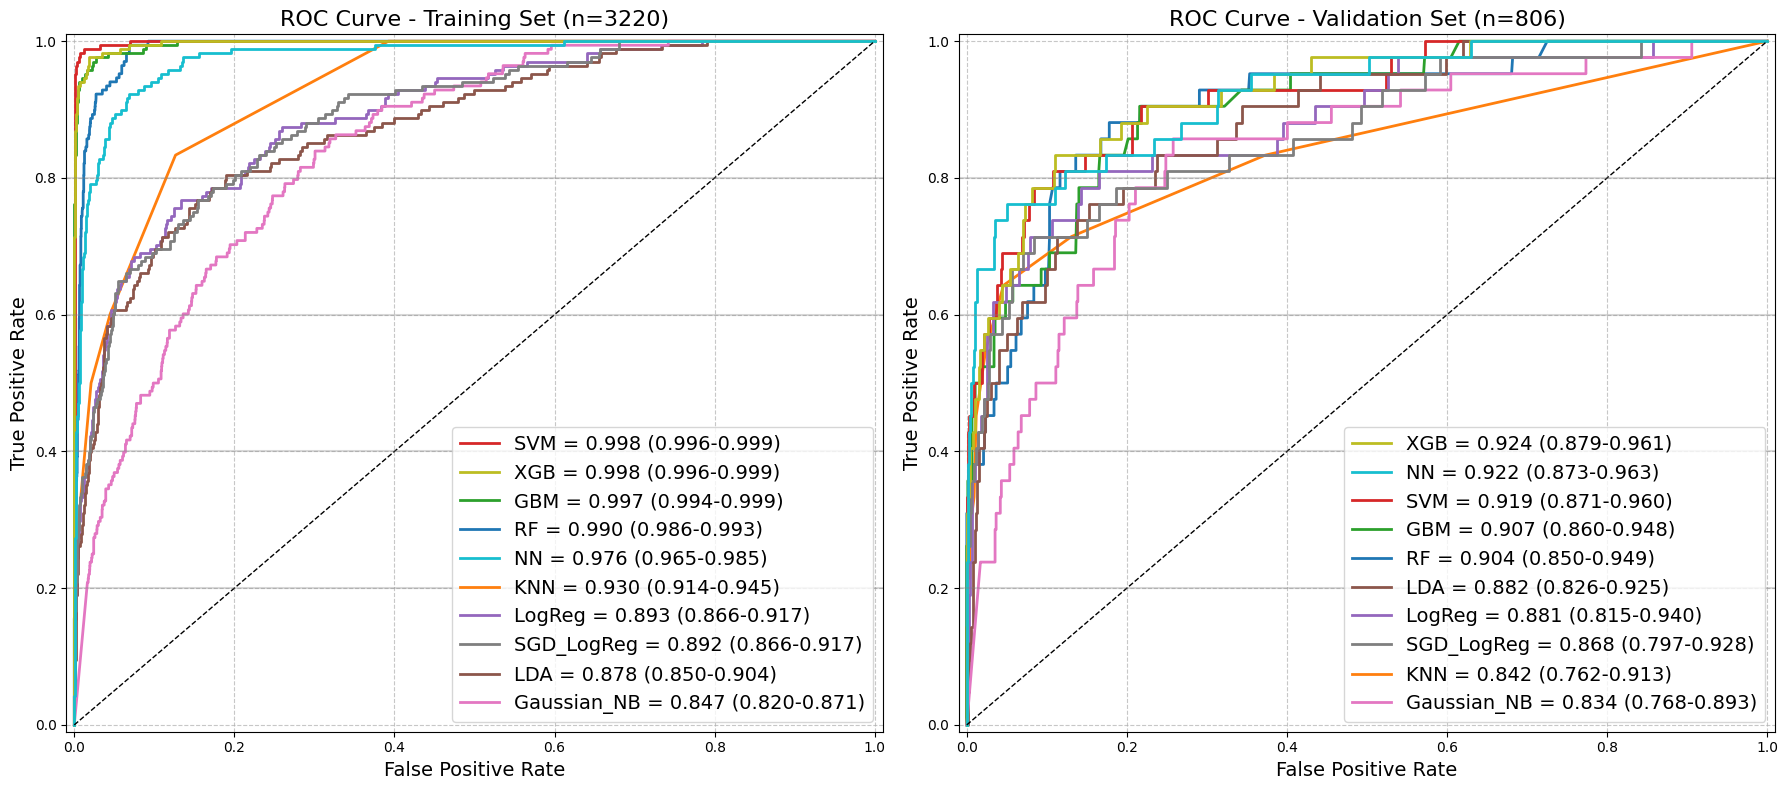

In [32]:
fig, models, results_train, results_test = train_and_plot_models(
     X, y, 
     save_path="model_comparison_roc_curves.png",
     models_dir="trained_models"
)

In [28]:
# 1. Train the best model on the entire training set
best_xgb = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42)

# Fit the model on the entire training set
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [29]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'XGB (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

External Validation (Test)


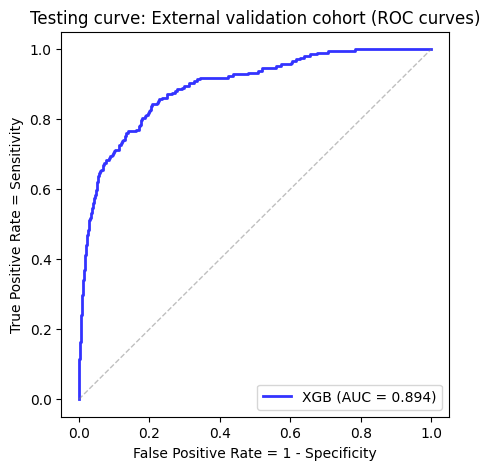

Val AUROC: 0.894 (95% CI: 0.870, 0.914)


In [30]:
print("External Validation (Test)")
pred_probas_test = best_xgb.predict_proba(X_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External validation cohort (ROC curves)')
#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_test[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")